In [45]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
import sklearn

from scipy import ndimage

from time import time

In [46]:
meta_data = pd.read_csv('../../../local_files/Projects/Instagram_Likes_Local/data/meta_data.csv')

In [47]:
meta_data.tail(2)

,caption,comments,image_urls,likes,user_url,username,insta_id,is_verified,following,full_name,followers,posts,pic_path,checksum
166286,NaN,3.0,http://scontent.cdninstagram.com/t51.2885-15/s...,43.0,http://www.imgrum.org/user/ofer7684/52646956,ofer7684,52646956.0,False,1273.0,Ofer Osherovitz,473.0,456.0,f76eef11891e4b184a48a2c4f508230f4b4c05e4.jpg,9d6d43f32ea2b49097726cc2763f714a
166287,#health #fitness #fit #TagsForLikes #TFLers #f...,0.0,http://scontent.cdninstagram.com/t51.2885-15/s...,27.0,http://www.imgrum.org/user/ofer7684/52646956,ofer7684,52646956.0,False,1273.0,Ofer Osherovitz,473.0,456.0,d2236c7d987e66ae718bf54ec2061df4f197cd7e.jpg,400e97645e0cf08c15b8f2fcbb8909eb


In [106]:
meta_data.caption.replace([np.NaN],['none'], inplace = True)
sunsets = []
for i in range(len(meta_data)-1):
    if meta_data.caption[i].find('#cat') > 0:
        sunsets.append(i)

In [107]:
len(sunsets)

2867

In [108]:
meta_data.caption[sunsets[:46]]

8578     Another side of Kurdistan. People fall in love...
8614     From the series "Secret Camps". About women an...
19454    I wish my relationship with bread could be thi...
19763    I wanted @oluwagbeminiyi's hairstyle and she w...
20368    My cat hates all of her 9 lives. #lookatherlil...
20422    With Frosted Mini Wheats. #catlady #mebaby #fe...
21642    My mom thinks I'm crazy. I agree. 😳 #jasmineon...
21646    Being in Arizona is like being on another plan...
21655    Off grid. \n#JasmineOnTheGo #freespirit #photo...
26284    PEOPLE OF INSTAGRAM. This is @butlersinstagram...
29305    Beautiful, beautiful industry event tonight! T...
30053    Introducing #Apricat. And yes, she is wearing ...
30069    Balance is good.\n\n#balance #shadowplay #whit...
30071    Accidental twin Thursday with my favorite boss...
30133    @marjicat and I avoid the heat before I got to...
30851    Happy #NationalCatDay to my bubs! #calico #cat...
31034                    Cheerios!! And a #catphotobomb 

In [12]:
meta_data['rating']=0
meta_data['f_over_f'] = meta_data.followers/meta_data.following

In [6]:
ff_mean = meta_data['f_over_f'].mean()

In [7]:
np.percentile(meta_data['f_over_f'].dropna(), np.arange(0, 100, 10))

array([  7.73333333e-02,   4.62209302e-01,   1.25659824e+00,
         2.15544472e+00,   3.90607735e+00,   8.65277778e+00,
         1.51181200e+01,   4.34337349e+01,   1.10288809e+02,
         6.65251429e+02])

In [8]:
super_users = meta_data[meta_data['f_over_f']>=43]['username'].unique()
reg_meta = meta_data[~meta_data['username'].isin(super_users)]
ver_reg = reg_meta[reg_meta['is_verified']==True].username.unique()
super_users = np.concatenate((super_users, ver_reg))

super_meta = meta_data[meta_data['username'].isin(super_users)]
reg_meta = meta_data[~meta_data['username'].isin(super_users)]

reg_users = reg_meta.username.unique()
reg_users = [x for x in reg_users if str(x) != 'nan']

In [9]:
super_meta[super_meta['username']=='brahmino'].likes.values

array([ 25518.,  28436.,  27550., ...,    137.,    154.,     62.])

In [10]:
def getSuperRating(username):
    df = super_meta[super_meta['username']==username].likes.values
    ind = super_meta[super_meta['username']==username].index.values
    increments = int(len(df)*.025)
    ratings = []
    for i in range(len(df)):    
        start = max(0, i-increments)
        end = min(len(df)-1, i+increments)
        mean = np.mean(df[start:end])
        std = np.std(df[start:end])
        if df[i]>=(mean + std*.3):
            ratings.append(3)
        elif df[i]<=(mean - std*.8):
            ratings.append(1)
        else:
            ratings.append(2)
        zipped = list(zip(ind,ratings))
        rate = pd.DataFrame(zipped,columns=['ind', 'updated_rating'])
        rate.set_index(['ind'], inplace=True)
    return rate

In [11]:
super_meta.rating.value_counts()

0    50353
Name: rating, dtype: int64

In [13]:
t0 = time()
for i in super_users:
    new_rated = getSuperRating(i)
    super_meta.rating.update(new_rated.updated_rating)
print("done in %0.3fs." % (time() - t0))

NameError: name 'super_users' is not defined

In [13]:
super_meta.rating.value_counts()

2    25806
3    15224
1     9323
Name: rating, dtype: int64

In [14]:
def getRegRating(username):
    df = reg_meta[reg_meta['username']==username].likes.values
    ind = reg_meta[reg_meta['username']==username].index.values
    increments = int(len(df)*.025)
    ratings = []
    for i in range(len(df)):    
        start = max(0, i-increments)
        end = min(len(df)-1, i+increments)
        mean = np.mean(df[start:end])
        std = np.std(df[start:end])
        if df[i]>=(mean + std*.6):
            ratings.append(3)
        elif df[i]<=(mean - std*.4):
            ratings.append(1)
        else:
            ratings.append(2)
        zipped = list(zip(ind,ratings))
        rate = pd.DataFrame(zipped,columns=['ind', 'updated_rating'])
        rate.set_index(['ind'], inplace=True)
    return rate

In [15]:
reg_meta.rating.value_counts()

0    115935
Name: rating, dtype: int64

In [16]:
t0 = time()
for i in reg_users:
    new_reg_rated = getRegRating(i)
    reg_meta.rating.update(new_reg_rated.updated_rating)
print("done in %0.3fs." % (time() - t0))

/Users/bauer/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/bauer/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/bauer/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


done in 133.882s.


In [17]:
reg_meta.rating.value_counts()

1    42392
2    41816
3    25820
0     5907
Name: rating, dtype: int64

In [18]:
reg_meta = reg_meta[reg_meta['rating']>0]

In [19]:
meta_data = super_meta.append(reg_meta)
meta_data.rating.value_counts()

2    67622
1    51715
3    41044
Name: rating, dtype: int64

In [27]:
clusters = meta_data[['pic_path', 'rating']]

In [29]:
data_path = '../../../local_files/Projects/Instagram_Likes_Local/data/'
clusters.to_csv(data_path+'clusters.csv', index = False)


In [22]:
from PIL import Image 
from PIL.ExifTags import TAGS, GPSTAGS

In [23]:
image = Image.open("../../../local_files/Projects/Instagram_Likes_Local/InstaImages/thumbs/small/fff192103dabc1b0526640d28741ebdcd27fea31.jpg")

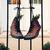

In [24]:
image

In [25]:
info = image._getexif() 
info

In [26]:
for tag, value in info.items(): 
    key = TAGS.get(tag, tag) 
    print(key + " " + str(value))

AttributeError: 'NoneType' object has no attribute 'items'

In [ ]:
image = Image.open("../../../local_files/Projects/Instagram_Likes_Local/InstaImages/full/fff192103dabc1b0526640d28741ebdcd27fea31.jpg")

In [ ]:
info = image._getexif()

In [ ]:
plt.boxplot(meta_data['flp'].dropna(),0, 'gD')